**Airbnb Calendar -Time-Series Analysis**

# Introduction



## Read in libraries, data, and set notebook preferences

**Read in libraries**

In [1]:
#Read in libraries
import fbprophet
from fbprophet.plot import plot_plotly

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

Importing plotly failed. Interactive plots will not work.
C:\Users\kishe\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Read in Data**

In [2]:
#Set path to local machine for data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\03_Processed/'

#Read in Airbnb Calendar listings data
bookings_df = pd.read_csv(path + '2020_0417_Booked_Listings.csv', sep = ',',dtype = {'available' : 'category'},
                       low_memory=True,index_col=0)

#Read in Airbnb Calendar prices data
income_df = pd.read_csv(path + '2020_0417_Daily_Net_Rental_Income.csv', sep = ',',dtype = {'available' : 'category'},
                       low_memory=True,index_col=0)

**Set notebook preferences**

In [3]:
#Supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

###Set plot aesthetics for notebook###
#Style
plt.style.use('Solarize_Light2')

#Title dictionary
title_dict = {'fontsize':16,
             'fontweight': 'bold'}
#Label dictionary
label_dict = {'fontsize':12,
             'fontweight': 'bold'}

# Data Overview

## Preview Airbnb Booked Listings Data

In [4]:
#Preview listings data
display(bookings_df.head())

,count
date,
2018-10-03,5897
2018-10-04,5806
2018-10-05,5847
2018-10-06,5822
2018-10-07,5493


## Data Information

In [5]:
#View listings info
bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 546 entries, 2018-10-03 to 2020-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   count   546 non-null    int64
dtypes: int64(1)
memory usage: 8.5+ KB


In [6]:
#Describe listings_df
bookings_df.describe()

,count
count,546.000000
mean,15480.673993
std,6326.237135
min,3978.000000
25%,10409.250000
50%,17639.000000
75%,20689.500000
max,25479.000000


**About the variables**

* date
* available 
* count

## Preview Airbnb Calendar Price Data

In [7]:
#Preview prices data
display(income_df.head())

,net_income
date,
2019-01-09,1322563.0
2019-01-10,1111389.0
2019-01-11,1062798.0
2019-01-12,1060895.0
2019-01-13,1008958.0


## Data Information

In [8]:
#View calendar info
income_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 448 entries, 2019-01-09 to 2020-03-31
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   net_income  448 non-null    float64
dtypes: float64(1)
memory usage: 7.0+ KB


In [9]:
income_df.describe()

,net_income
count,4.480000e+02
mean,3.263110e+06
std,1.312005e+06
min,8.697280e+05
25%,2.045759e+06
50%,3.570038e+06
75%,4.354748e+06
max,5.783902e+06


**About the variables**

* date
* available 
* count

# Time Series Analysis - Bookings Count

## Quick Exploratory Data Analysis

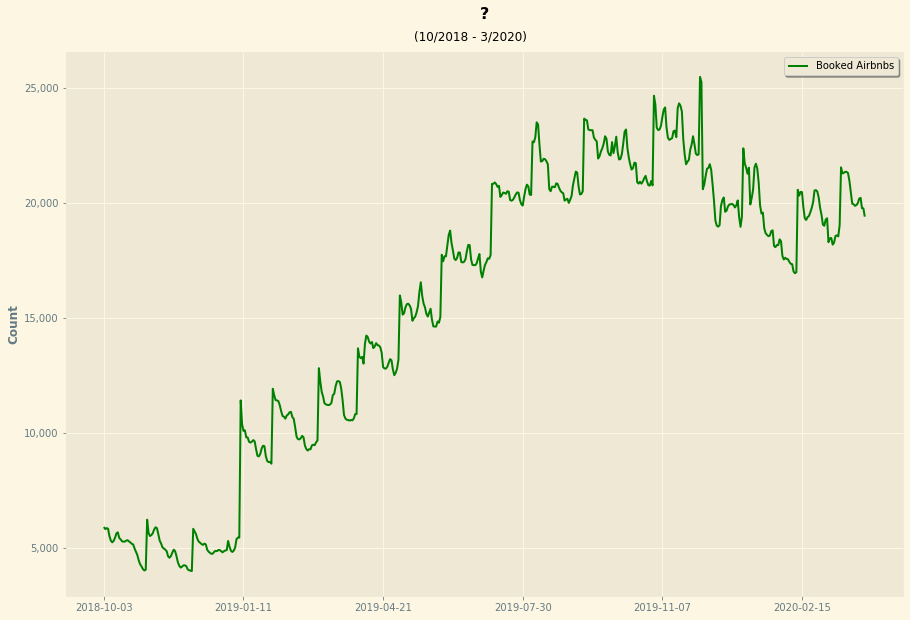

In [10]:
#Set figure size
fig, ax = plt.subplots(figsize = (15,10))
#Visualize airbnbs data
g = bookings_df.plot(y = 'count', ax=ax, color = 'g')

###Set plot Aesthetics###
#Title
ax.set_title('?', fontdict = title_dict, y = 1.05)
plt.suptitle('(10/2018 - 3/2020)', y = .91)

#Axes
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Labels
ax.set_ylabel('Count', fontdict = label_dict)
ax.set_xlabel('')

#Legend
ax.legend(labels = ['Booked Airbnbs'],frameon = True, shadow = True)

**Decompose Original Time-Series Data**

In [11]:
#Convert index to DateTimeIndex
bookings_df.reset_index(inplace=True)
bookings_df.date = pd.to_datetime(bookings_df.date)
bookings_df.set_index('date', inplace=True)

#Check
display(bookings_df.head())

,count
date,
2018-10-03,5897
2018-10-04,5806
2018-10-05,5847
2018-10-06,5822
2018-10-07,5493


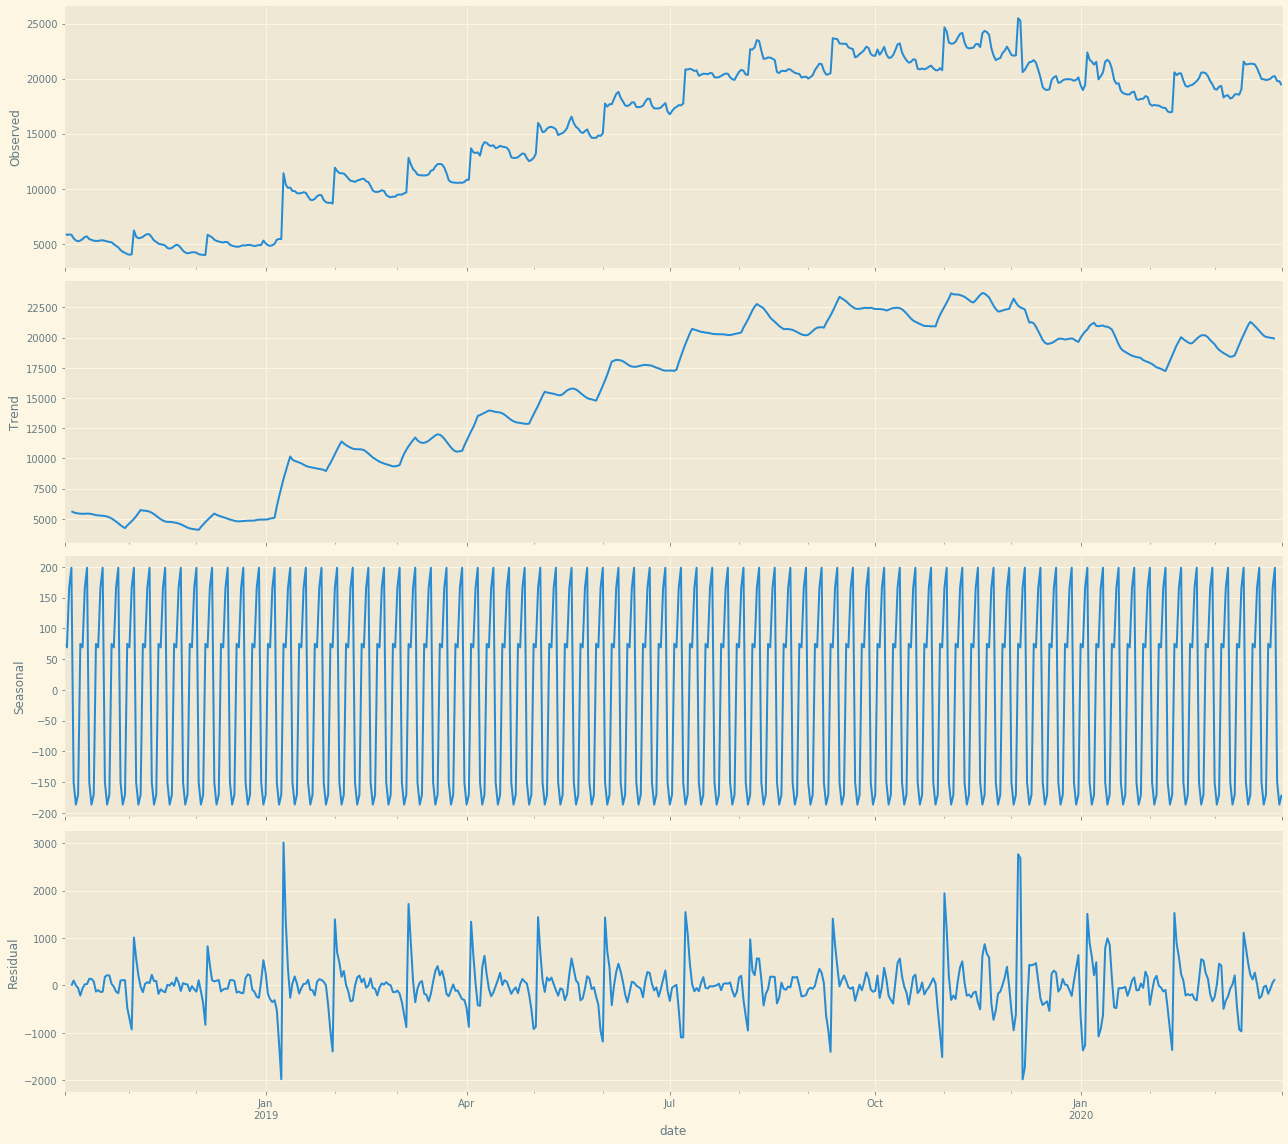

In [50]:
#Read in seasonal decompose model
from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams
rcParams['figure.figsize'] = 18, 16

#Fit seasonal_decompose to airbnb data
result = seasonal_decompose(bookings_df, model='additive')

#Plot
result.plot();

Removing Non-Stationarity

**Detrend Data**

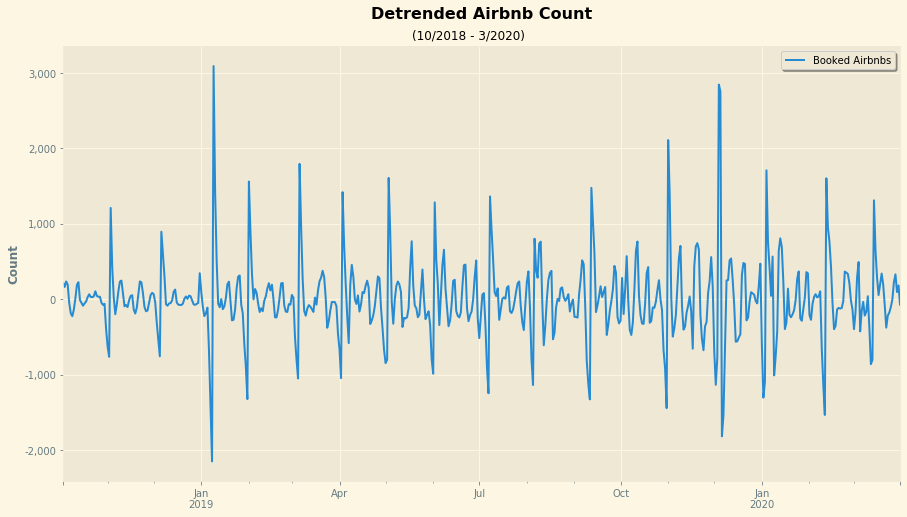

In [73]:
#Apply seasonal_decompose to count of bookings_df
result_add = seasonal_decompose(bookings_df['count'], model= 'additive',extrapolate_trend='freq')

#Detrend bookings_df['count']
detrended = bookings_df['count'] - result_add.trend

#Plot detrended data
j = detrended.plot(figsize = (15,8))

###Set plot Aesthetics###
#Title
j.set_title('Detrended Airbnb Count', fontdict = title_dict, y = 1.05)
plt.suptitle('(10/2018 - 3/2020)', y = .91)

#Axes
j.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Labels
j.set_ylabel('Count', fontdict = label_dict)
j.set_xlabel('')

#Legend
j.legend(labels = ['Booked Airbnbs'],frameon = True, shadow = True)


**Remove Seasonality**

In [74]:
detrended

date
2018-10-03    221.204082
2018-10-04    161.918367
2018-10-05    234.632653
2018-10-06    193.857143
2018-10-07    -48.857143
                 ...    
2020-03-27    228.000000
2020-03-28    329.000000
2020-03-29     93.780612
2020-03-30    181.540816
2020-03-31    -84.698980
Name: count, Length: 546, dtype: float64

In [70]:
log_bookings_df = np.log(bookings_df)
log_bookings_df

,count
date,
2018-10-03,8.682199
2018-10-04,8.666647
2018-10-05,8.673684
2018-10-06,8.669399
2018-10-07,8.611230
...,...
2020-03-27,9.912596
2020-03-28,9.914279
2020-03-29,9.891820


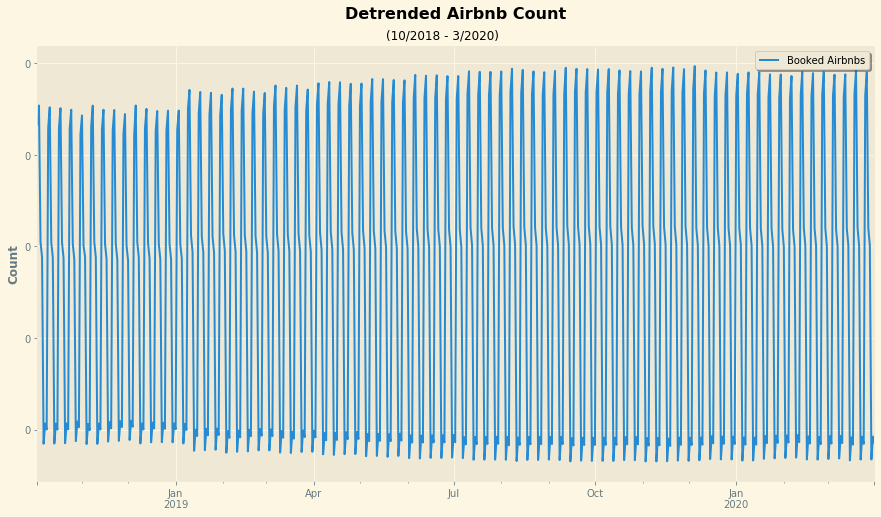

In [71]:
log_bookings_df = np.log(bookings_df)

#Remove seasolity from detrended
deseasoned = log_bookings_df['count']/result_add.seasonal

#Plot deseasonedd data
j = deseasoned.plot(figsize = (15,8))

###Set plot Aesthetics###
#Title
j.set_title('Detrended Airbnb Count', fontdict = title_dict, y = 1.05)
plt.suptitle('(10/2018 - 3/2020)', y = .91)

#Axes
j.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Labels
j.set_ylabel('Count', fontdict = label_dict)
j.set_xlabel('')

#Legend
j.legend(labels = ['Booked Airbnbs'],frameon = True, shadow = True)

**Rolling mean and standard deviation**

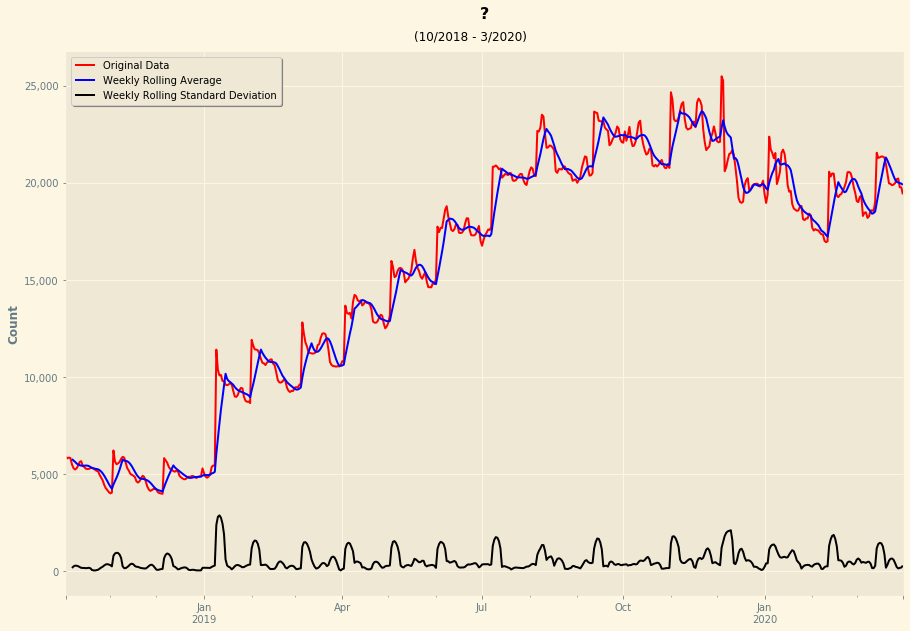

In [41]:
#Set figure size
fig, ax = plt.subplots(figsize = (15,10))

#Plot original airbnbs data
g = bookings_df.plot(y = 'count', ax=ax, color = 'r')

#Plot weekly rolling mean
j = bookings_df.rolling(7, min_periods= 5).mean().plot(ax = ax, color = 'blue')

#Plot weekly rolling sd
k = bookings_df.rolling(7, min_periods= 5).std().plot(ax = ax, color = 'black')

###Set plot Aesthetics###
#Title
ax.set_title('?', fontdict = title_dict, y = 1.05)
plt.suptitle('(10/2018 - 3/2020)', y = .91)

#Axes
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Labels
ax.set_ylabel('Count', fontdict = label_dict)
ax.set_xlabel('')

#Legend
ax.legend(labels = ['Original Data', 'Weekly Rolling Average', 'Weekly Rolling Standard Deviation'],
          loc = 'upper left',frameon = True, shadow = True)

### Apply models for forcasting

Implement Smoothing Models

In [ ]:
Implement SARIMA

In [ ]:
Implement Prophet Model

# Time Series Analysis - Rental Income

## Quick Exploratory Data Analysis